<a href="https://colab.research.google.com/github/lucckkas/TallerIntegrado/blob/main/Unidad1ProductoComputacional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ¿Qué es MHEALTH?

**MHEALTH** (Mobile Health) es un conjunto de datos usado para estudiar el **reconocimiento de actividades humanas** a partir de sensores que llevan las personas mientras realizan acciones cotidianas (caminar, subir escaleras, correr, etc.).

- **Participantes:** 10 sujetos voluntarios.  
- **Actividades etiquetadas:** 12 (por ejemplo: estar de pie, sentarse relajado, caminar, correr...).  
- **Sensores:** acelerómetro, giroscopio y magnetómetro en **tobillo izquierdo** y **antebrazo derecho**, más **acelerómetro** y **ECG** (electrocardiograma) en el **pecho**.  





# Librerías y opciones

In [1]:
import pathlib, zipfile, re, pandas as pd, numpy as np
from urllib.request import urlretrieve

pd.options.display.max_columns = 60
DATA_DIR = pathlib.Path("data"); DATA_DIR.mkdir(exist_ok=True)
LOG_DIR = DATA_DIR / "MHEALTHDATASET"
ZIP_PATH = DATA_DIR / "mhealth_dataset.zip"


# Descarga y unzip

En esta primera parte **solo** haremos la **carga del dataset** y dejaremos el conjunto de datos listo para su análisis:
- Descargaremos el archivo comprimido (**ZIP**) desde la página oficial.
- Leeremos los archivos de cada participante y los uniremos en una sola tabla.
- Le daremos **nombres claros** a las columnas.
- Añadiremos el nombre de la actividad a partir del número de etiqueta.
- Haremos **verificaciones mínimas** para asegurar que todo se cargó bien.


In [2]:
url = "https://archive.ics.uci.edu/static/public/319/mhealth+dataset.zip"
urlretrieve(url, ZIP_PATH)

with zipfile.ZipFile(ZIP_PATH, "r") as z:
    z.extractall(DATA_DIR)

sorted(p.name for p in LOG_DIR.glob("mHealth_subject*.log"))[:5]


['mHealth_subject1.log',
 'mHealth_subject10.log',
 'mHealth_subject2.log',
 'mHealth_subject3.log',
 'mHealth_subject4.log']

In [3]:
# esquema de columnas
COLUMNS = [
    "chest_acc_x","chest_acc_y","chest_acc_z",     # 1-3
    "ecg_1","ecg_2",                               # 4-5
    "left_ankle_acc_x","left_ankle_acc_y","left_ankle_acc_z",  # 6-8
    "left_ankle_gyro_x","left_ankle_gyro_y","left_ankle_gyro_z",  # 9-11
    "left_ankle_mag_x","left_ankle_mag_y","left_ankle_mag_z",  # 12-14
    "right_lower_arm_acc_x","right_lower_arm_acc_y","right_lower_arm_acc_z",  # 15-17
    "right_lower_arm_gyro_x","right_lower_arm_gyro_y","right_lower_arm_gyro_z",  # 18-20
    "right_lower_arm_mag_x","right_lower_arm_mag_y","right_lower_arm_mag_z",  # 21-23
    "label",  # 24 (0 = null)
]


In [4]:
# Celda 4: lectura de todos los sujetos y unión
def _subject_id(path: pathlib.Path) -> int:
    m = re.search(r"subject(\d+)", path.stem)
    return int(m.group(1)) if m else -1

dtype_map = {**{c: "float32" for c in COLUMNS[:-1]}, "label": "int8"}
dfs = []

for log_path in sorted(LOG_DIR.glob("mHealth_subject*.log")):
    sid = _subject_id(log_path)
    df_i = pd.read_csv(
        log_path,
        sep=r"\s+",
        header=None,
        names=COLUMNS,
        engine="python",
        dtype=dtype_map,
    )
    df_i["subject_id"] = np.int16(sid)
    dfs.append(df_i)

df = pd.concat(dfs, ignore_index=True)
df.shape


(1215745, 25)

In [5]:
# Celda 5: mapa de etiquetas (incluyendo clase nula 0)
label_map = {
    0: "Null",
    1: "Standing still",
    2: "Sitting and relaxing",
    3: "Lying down",
    4: "Walking",
    5: "Climbing stairs",
    6: "Waist bends forward",
    7: "Frontal elevation of arms",
    8: "Knees bending (crouching)",
    9: "Cycling",
    10: "Jogging",
    11: "Running",
    12: "Jump front & back",
}
df["activity"] = df["label"].map(label_map).astype("category")


In [6]:
# Celda 6: verificaciones
assert {"label", "activity"}.issubset(df.columns)
assert df["label"].between(0, 12).all(), "Hay etiquetas fuera de 0..12"
print("Filas, columnas:", df.shape)
print("Sujetos:", df["subject_id"].nunique())
print("Muestras por etiqueta:")
print(df["label"].value_counts().sort_index())
df.sample(5, random_state=42)


Filas, columnas: (1215745, 26)
Sujetos: 10
Muestras por etiqueta:
label
0     872550
1      30720
2      30720
3      30720
4      30720
5      30720
6      28315
7      29441
8      29337
9      30720
10     30720
11     30720
12     10342
Name: count, dtype: int64


,chest_acc_x,chest_acc_y,chest_acc_z,ecg_1,ecg_2,left_ankle_acc_x,left_ankle_acc_y,left_ankle_acc_z,left_ankle_gyro_x,left_ankle_gyro_y,left_ankle_gyro_z,left_ankle_mag_x,left_ankle_mag_y,left_ankle_mag_z,right_lower_arm_acc_x,right_lower_arm_acc_y,right_lower_arm_acc_z,right_lower_arm_gyro_x,right_lower_arm_gyro_y,right_lower_arm_gyro_z,right_lower_arm_mag_x,right_lower_arm_mag_y,right_lower_arm_mag_z,label,subject_id,activity
637239,-9.1505,0.96078,-3.2083,0.016745,0.146520,-0.045586,-9.8224,0.92509,-0.725420,-0.71670,0.220040,0.38733,0.363100,-0.877180,-8.19310,-4.8362,-0.61681,-0.972550,0.11294,-0.25431,0.545730,0.71331,-0.71824,2,5,Sitting and relaxing
962780,-9.1949,-0.86276,3.3434,-0.121400,-0.113030,1.355100,-9.6800,0.32122,-0.647500,-0.25704,0.662080,0.19805,0.364990,-0.584810,-2.41230,-9.4444,-0.44097,-0.772550,-0.22177,-0.32543,0.181260,0.17247,-0.72012,1,8,Standing still
834341,-9.0718,-1.45900,-2.5629,0.389320,0.251180,3.857800,-9.0872,1.17800,0.048237,-0.30582,0.701380,-22.51700,-21.976999,-7.555000,-0.28752,-9.2101,3.98740,-0.568630,-0.17454,0.64440,-6.750500,-10.77500,4.66590,0,6,Null
627470,-6.5283,2.17490,-7.8569,0.774460,0.079540,3.936700,-11.0340,-12.26200,-0.591840,-0.75610,-0.086444,-2.31360,110.480003,53.054001,1.82840,-9.2918,-3.18330,-0.066667,-0.74949,-0.73922,17.009001,13.26200,0.20755,0,4,Null
265172,-9.6662,-0.53064,1.9838,-0.154890,-0.025118,1.675400,-9.6663,-0.28948,-0.263450,-0.73358,0.636540,0.18517,0.732090,-0.155320,-2.80470,-8.2609,3.90990,-0.880390,-0.83368,0.34914,-0.353730,0.53344,-1.45650,0,2,Null


### ¿Está bien la carga? (resumen interpretado)

- **Tamaño:** 1,215,745 filas y 26 columnas.  
  - 24 campos vienen del dataset original (23 señales + la etiqueta `label`).
  - Agregamos `subject_id` (quién es la persona) y `activity` (nombre legible de la etiqueta).
- **Sujetos:** 10 (correcto para MHEALTH).
- **Etiquetas presentes:** 0 a 12. La etiqueta **0** es “Null” (transición/tiempos muertos), por eso tiene muchas más filas.

Con esto en mente la carga parece estar correcta.


## Exploración inicial del dataset

**Qué haremos aquí:**
- Mirar dimensiones y tipos de vairables.
- Ver si existen valores faltantes.
- Obtener estadísticas básicas (mínimos, medianas, percentiles).
- Visualizar distribuciones simples y frecuencias por actividad.


> Nota: para que los gráficos sean ágiles con este tamaño de datos (~1.2 millones de filas), a veces usaremos **muestras** en lugar de todos los registros.


# Constantes y utilidades

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Constantes (50 Hz del dataset)
SAMPLE_RATE = 50


# Columnas numéricas (todas menos label/activity/subject_id)
# Se excluyen estas porque son categorias y no tendria sentido calcular medias u otros valores estadisticos
num_cols = [c for c in df.columns if c not in ("label", "activity", "subject_id")]

def mem_megabytes(df_: pd.DataFrame) -> float:
    """Uso de memoria en MB (aprox)."""
    return df_.memory_usage(deep=True).sum() / (1024**2)

def percent_missing(s: pd.Series) -> float:
    """Porcentaje de faltantes en una serie."""
    return 100.0 * s.isna().sum() / len(s)

def quick_hist(series: pd.Series, title: str, bins: int = 60):
    """Histograma simple y legible con Matplotlib."""
    plt.figure(figsize=(6,3.5))
    plt.hist(series, bins=bins)
    plt.title(title)
    plt.xlabel(series.name)
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()


### Dimensiones, tipos de datos y memoria

Primero verificamos:
- el **tamaño** de la tabla,
- los **tipos de datos** (enteros, decimales, categorías),

También miramos un **muestrario** de filas para confirmar que los nombres de columnas y los valores tienen sentido.


In [8]:
import io

print("Dimensiones (filas, columnas):", df.shape)
print("\nTipos de datos:")
print(df.dtypes.value_counts(), "\n")

# info resumida
buf = io.StringIO()
df.info(buf=buf, memory_usage="deep")
info_str = buf.getvalue()

print("\n".join(info_str.splitlines()[:30]))

print("\nMuestra aleatoria de 5 filas:")
display(df.sample(5, random_state=RANDOM_STATE))


Dimensiones (filas, columnas): (1215745, 26)

Tipos de datos:
float32     23
int8         1
int16        1
category     1
Name: count, dtype: int64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1215745 entries, 0 to 1215744
Data columns (total 26 columns):
 #   Column                  Non-Null Count    Dtype   
---  ------                  --------------    -----   
 0   chest_acc_x             1215745 non-null  float32 
 1   chest_acc_y             1215745 non-null  float32 
 2   chest_acc_z             1215745 non-null  float32 
 3   ecg_1                   1215745 non-null  float32 
 4   ecg_2                   1215745 non-null  float32 
 5   left_ankle_acc_x        1215745 non-null  float32 
 6   left_ankle_acc_y        1215745 non-null  float32 
 7   left_ankle_acc_z        1215745 non-null  float32 
 8   left_ankle_gyro_x       1215745 non-null  float32 
 9   left_ankle_gyro_y       1215745 non-null  float32 
 10  left_ankle_gyro_z       1215745 non-null  float32 
 11  left

,chest_acc_x,chest_acc_y,chest_acc_z,ecg_1,ecg_2,left_ankle_acc_x,left_ankle_acc_y,left_ankle_acc_z,left_ankle_gyro_x,left_ankle_gyro_y,left_ankle_gyro_z,left_ankle_mag_x,left_ankle_mag_y,left_ankle_mag_z,right_lower_arm_acc_x,right_lower_arm_acc_y,right_lower_arm_acc_z,right_lower_arm_gyro_x,right_lower_arm_gyro_y,right_lower_arm_gyro_z,right_lower_arm_mag_x,right_lower_arm_mag_y,right_lower_arm_mag_z,label,subject_id,activity
637239,-9.1505,0.96078,-3.2083,0.016745,0.146520,-0.045586,-9.8224,0.92509,-0.725420,-0.71670,0.220040,0.38733,0.363100,-0.877180,-8.19310,-4.8362,-0.61681,-0.972550,0.11294,-0.25431,0.545730,0.71331,-0.71824,2,5,Sitting and relaxing
962780,-9.1949,-0.86276,3.3434,-0.121400,-0.113030,1.355100,-9.6800,0.32122,-0.647500,-0.25704,0.662080,0.19805,0.364990,-0.584810,-2.41230,-9.4444,-0.44097,-0.772550,-0.22177,-0.32543,0.181260,0.17247,-0.72012,1,8,Standing still
834341,-9.0718,-1.45900,-2.5629,0.389320,0.251180,3.857800,-9.0872,1.17800,0.048237,-0.30582,0.701380,-22.51700,-21.976999,-7.555000,-0.28752,-9.2101,3.98740,-0.568630,-0.17454,0.64440,-6.750500,-10.77500,4.66590,0,6,Null
627470,-6.5283,2.17490,-7.8569,0.774460,0.079540,3.936700,-11.0340,-12.26200,-0.591840,-0.75610,-0.086444,-2.31360,110.480003,53.054001,1.82840,-9.2918,-3.18330,-0.066667,-0.74949,-0.73922,17.009001,13.26200,0.20755,0,4,Null
265172,-9.6662,-0.53064,1.9838,-0.154890,-0.025118,1.675400,-9.6663,-0.28948,-0.263450,-0.73358,0.636540,0.18517,0.732090,-0.155320,-2.80470,-8.2609,3.90990,-0.880390,-0.83368,0.34914,-0.353730,0.53344,-1.45650,0,2,Null


### Valores faltantes

Comprobamos si hay **valores faltantes** (`NaN`).  
Si los hay, cuantificamos su porcentaje por columna.  
Esto guía decisiones de limpieza (imputación, eliminación, etc.).


In [9]:
na_counts = df.isna().sum()
total_na = int(na_counts.sum())
print("Total de valores faltantes en todo el DataFrame:", total_na)

if total_na > 0:
    na_pct = (na_counts / len(df) * 100).round(4).sort_values(ascending=False)
    display(na_pct[na_pct > 0])
else:
    print("No se detectaron valores faltantes.")


Total de valores faltantes en todo el DataFrame: 0
No se detectaron valores faltantes.


### Estadísticas básicas (por columna)

Calculamos:
- medidas como **min**, **mediana**, **max**,
- percentiles **P1, P5, P95, P99**,
- y apoyos para detectar posibles **valores atípicos** (IQR).


In [10]:
percentiles = [0.01, 0.05, 0.5, 0.95, 0.99]
desc = df[num_cols].describe(percentiles=percentiles).T

# IQR y límites "tipo Tukey" (Q1-1.5*IQR, Q3+1.5*IQR)
q1 = df[num_cols].quantile(0.25)
q3 = df[num_cols].quantile(0.75)
iqr = q3 - q1
low_whisker  = q1 - 1.5 * iqr
high_whisker = q3 + 1.5 * iqr

summary = desc.join(pd.DataFrame({
    "iqr": iqr,
    "low_whisker": low_whisker,
    "high_whisker": high_whisker
}))
summary.round(4)


,count,mean,std,min,1%,5%,50%,95%,99%,max,iqr,low_whisker,high_whisker
chest_acc_x,1215745.0,-8.5224,4.0739,-22.4380,-21.7920,-13.8050,-9.3114,0.0964,3.9301,19.0940,2.1669,-13.0543,-4.3868
chest_acc_y,1215745.0,-0.2140,2.1383,-20.1880,-5.7422,-3.2421,-0.3538,3.2317,6.4279,20.9270,1.9827,-4.2469,3.6838
chest_acc_z,1215745.0,-1.0559,3.5720,-18.4010,-10.2310,-6.9336,-0.8702,4.1305,9.6815,26.1960,3.5932,-8.2571,6.1157
ecg_1,1215745.0,-0.0051,0.7462,-8.6196,-1.9634,-0.9712,-0.0712,1.1680,2.7671,8.5149,0.3935,-0.8247,0.7493
ecg_2,1215745.0,-0.0045,0.7266,-8.6196,-2.0345,-0.7954,-0.0419,0.9838,2.2815,8.5191,0.3391,-0.6970,0.6593
left_ankle_acc_x,1215745.0,1.4942,3.8237,-22.1460,-11.1106,-2.8362,1.3089,7.0722,15.9566,20.0540,2.4345,-3.5104,6.2275
left_ankle_acc_y,1215745.0,-9.6929,4.1680,-19.6190,-19.3580,-19.1120,-9.6703,-1.8956,1.5752,21.1610,1.1588,-11.9392,-7.3040
left_ankle_acc_z,1215745.0,-0.9548,5.4599,-19.3730,-18.7480,-11.0620,-0.0165,7.4698,12.2621,25.0150,3.9507,-8.5755,7.2274
left_ankle_gyro_x,1215745.0,-0.0016,0.4911,-2.1466,-0.8924,-0.6939,-0.0148,0.7217,0.8442,60.4840,0.8850,-1.7634,1.7764
left_ankle_gyro_y,1215745.0,-0.6166,0.3544,-7.7899,-1.1013,-0.9381,-0.7073,0.0225,0.9456,2.0113,0.2777,-1.2345,-0.1238


### ¿Qué muestra esta tabla de estadísticas?

La tabla resume, por cada señal, valores descriptivos básicos: cantidad de muestras, promedio, dispersión y rangos (mínimo/máximo y percentiles). En general:

- **Acelerómetros**: valores en rangos esperados (~±20). Algunas medias negativas reflejan la orientación del sensor respecto a la gravedad (ej., `chest_acc_x ≈ -8.5`, `left_ankle_acc_y ≈ -9.7`).
- **Giroscopios**: dispersión moderada, pero aparece algún **pico atípico** (ej., `left_ankle_gyro_x` con máx ~60.5), típico de golpes/giros bruscos o mediciones ruidosas.
- **Magnetómetros**: mayor variabilidad y **extremos** (p. ej., `right_lower_arm_mag_z` ~±700). Es usual ver offset/interferencias si no hay calibración fina.
- **ECG**: señales centradas ≈0 con desviación ~0.7, coherentes con datos crudos.

Los límites **low/high whisker** (basados en IQR) sirven para detectar **potenciales outliers**: valores muy por encima/debajo de estos límites merecen tratamiento en la fase de limpieza.


### ¿Cuántas muestras tiene cada actividad?

Mostramos la **distribución de etiquetas** (con y sin la clase `0 = Null`).


,count,activity
label,,
0,872550,Null
1,30720,Standing still
2,30720,Sitting and relaxing
3,30720,Lying down
4,30720,Walking
5,30720,Climbing stairs
6,28315,Waist bends forward
7,29441,Frontal elevation of arms
8,29337,Knees bending (crouching)


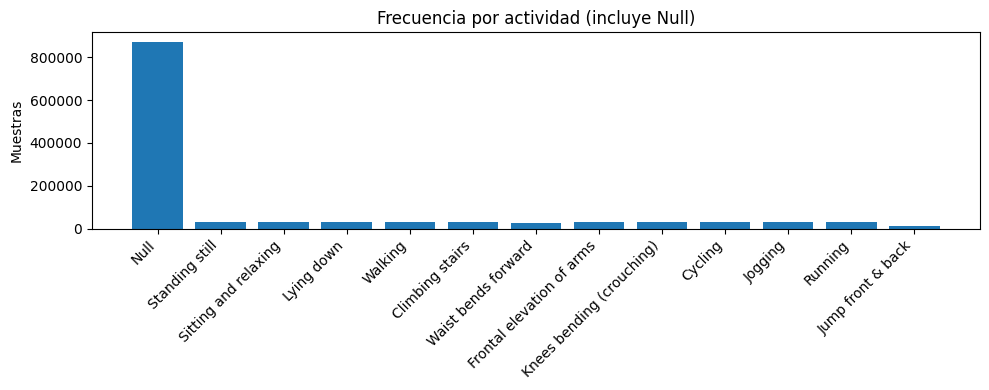

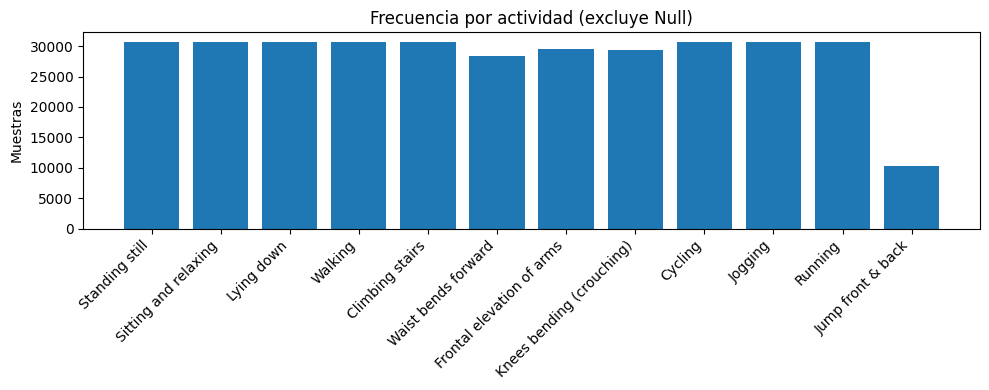

In [11]:
# Conteo por etiqueta (incluye Null)
counts_all = df['label'].value_counts().sort_index()
display(counts_all.to_frame(name='count').assign(activity=lambda t: t.index.map(label_map)))

# Gráfico (todas las etiquetas)
plt.figure(figsize=(10,4))
plt.bar([label_map[i] for i in counts_all.index], counts_all.values)
plt.xticks(rotation=45, ha='right')
plt.title("Frecuencia por actividad (incluye Null)")
plt.ylabel("Muestras")
plt.tight_layout()
plt.show()

# Gráfico sin Null para ver mejor las actividades "reales"
mask_real = df['label'] != 0
counts_real = df.loc[mask_real, 'label'].value_counts().sort_index()

plt.figure(figsize=(10,4))
plt.bar([label_map[i] for i in counts_real.index], counts_real.values)
plt.xticks(rotation=45, ha='right')
plt.title("Frecuencia por actividad (excluye Null)")
plt.ylabel("Muestras")
plt.tight_layout()
plt.show()


### ¿Todos los participantes hicieron todas las actividades?

Una tabla `sujeto × actividad` ayuda a ver si hay **actividades faltantes** en algún sujeto o grandes diferencias de cantidad.


In [12]:
per_subject = df.groupby(['subject_id','label']).size().unstack(fill_value=0).sort_index()
# Renombramos columnas numéricas a nombres legibles (sin perder el label)
per_subject.columns = [f"{col:02d}-{label_map.get(col, str(col))}" for col in per_subject.columns]
per_subject


,00-Null,01-Standing still,02-Sitting and relaxing,03-Lying down,04-Walking,05-Climbing stairs,06-Waist bends forward,07-Frontal elevation of arms,08-Knees bending (crouching),09-Cycling,10-Jogging,11-Running,12-Jump front & back
subject_id,,,,,,,,,,,,,
1,126106,3072,3072,3072,3072,3072,3072,3072,3379,3072,3072,3072,1075
2,95029,3072,3072,3072,3072,3072,3174,3328,3430,3072,3072,3072,1024
3,86732,3072,3072,3072,3072,3072,3226,3379,3175,3072,3072,3072,1024
4,81408,3072,3072,3072,3072,3072,3328,3277,3123,3072,3072,3072,1024
5,85861,3072,3072,3072,3072,3072,2765,2868,2714,3072,3072,3072,1024
6,66099,3072,3072,3072,3072,3072,2202,2099,2304,3072,3072,3072,1024
7,70195,3072,3072,3072,3072,3072,3072,2765,2816,3072,3072,3072,1024
8,95692,3072,3072,3072,3072,3072,2151,3021,2560,3072,3072,3072,1024
9,100814,3072,3072,3072,3072,3072,2867,2867,2969,3072,3072,3072,1075


### Distribuciones de señales (histogramas)

Hacemos histogramas para un **subconjunto** de variables (muestra aleatoria de filas) para evitar tiempos largos.


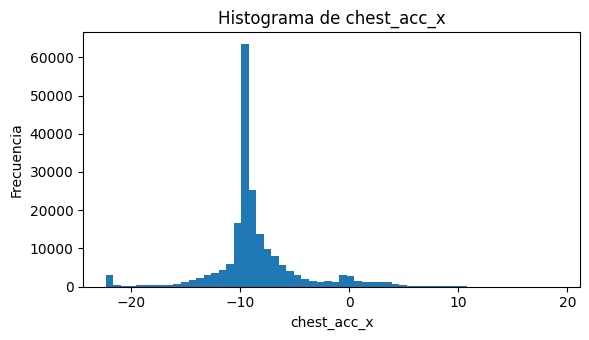

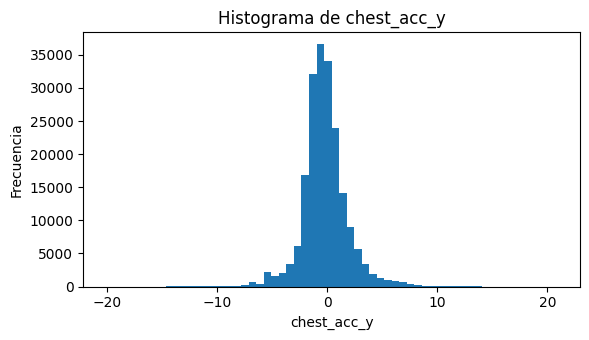

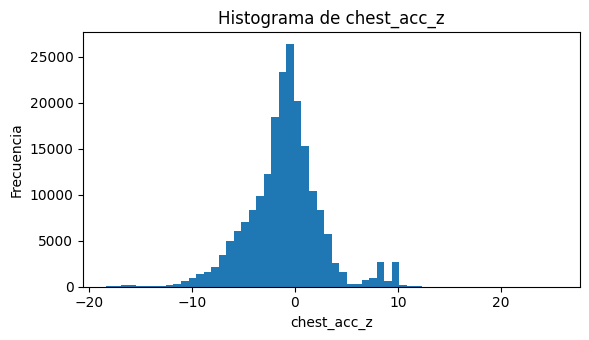

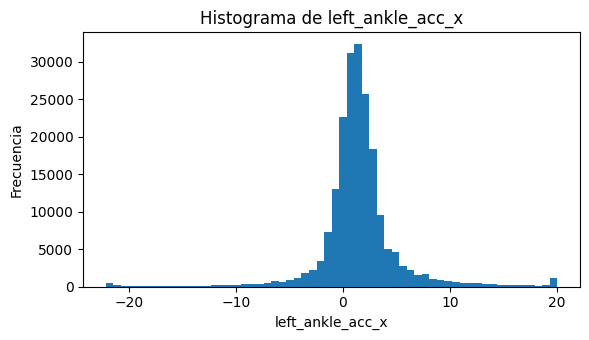

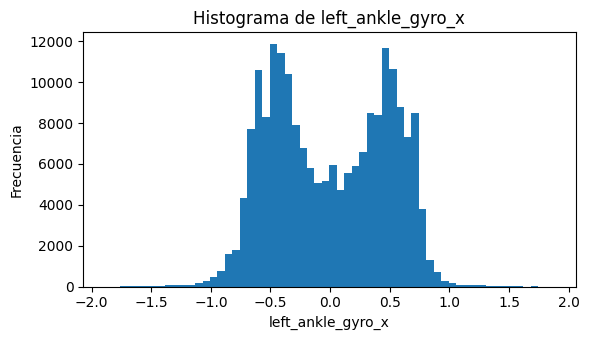

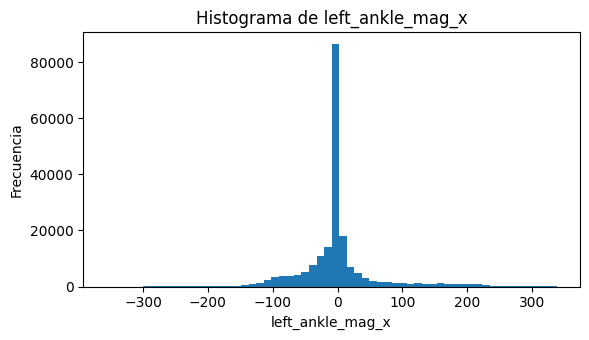

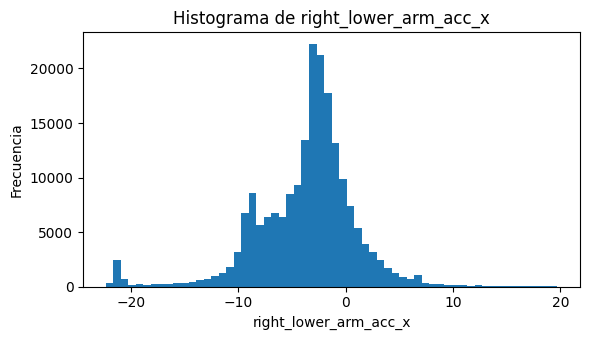

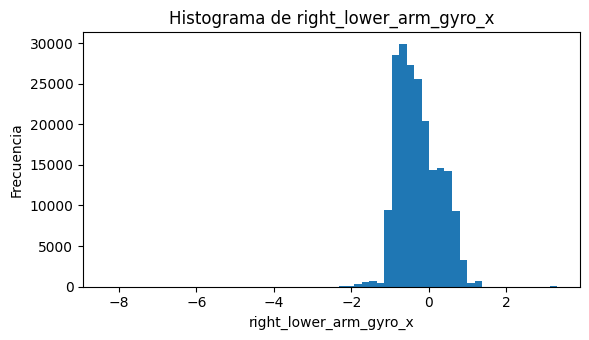

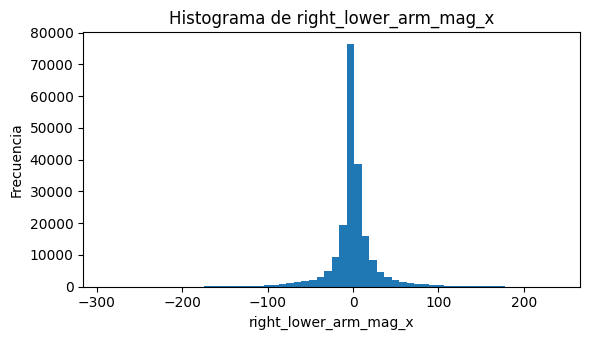

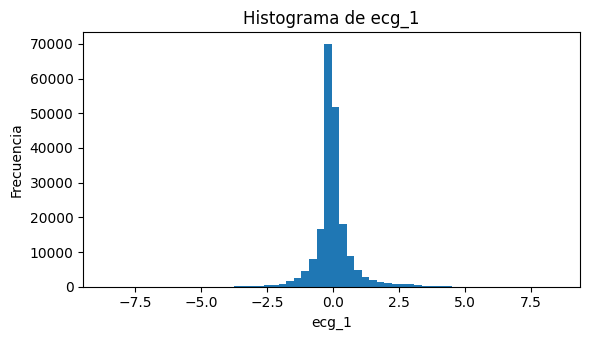

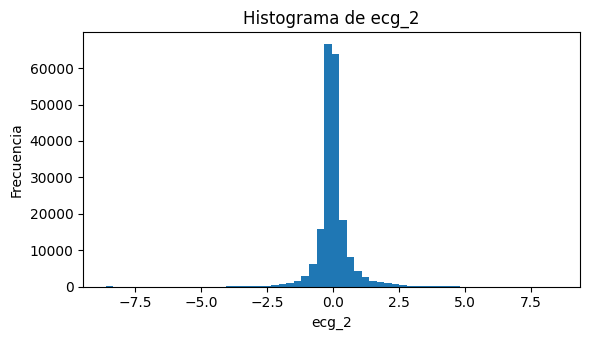

In [13]:
# Seleccionamos algunas columnas representativas
cols_demo = [
    "chest_acc_x", "chest_acc_y", "chest_acc_z",
    "left_ankle_acc_x", "left_ankle_gyro_x", "left_ankle_mag_x",
    "right_lower_arm_acc_x", "right_lower_arm_gyro_x", "right_lower_arm_mag_x",
    "ecg_1", "ecg_2"
]

# Muestra para graficar
n = 200_000 if len(df) > 200_000 else len(df)
sample = df[cols_demo].sample(n=n, random_state=RANDOM_STATE)

for c in cols_demo:
    quick_hist(sample[c].dropna(), title=f"Histograma de {c}", bins=60)


### Correlación entre señales

Una **matriz de correlación** ayuda a detectar relaciones fuertes entre sensores/ejes.
Esto puede orientar a **reducción de dimensionalidad** más adelante.


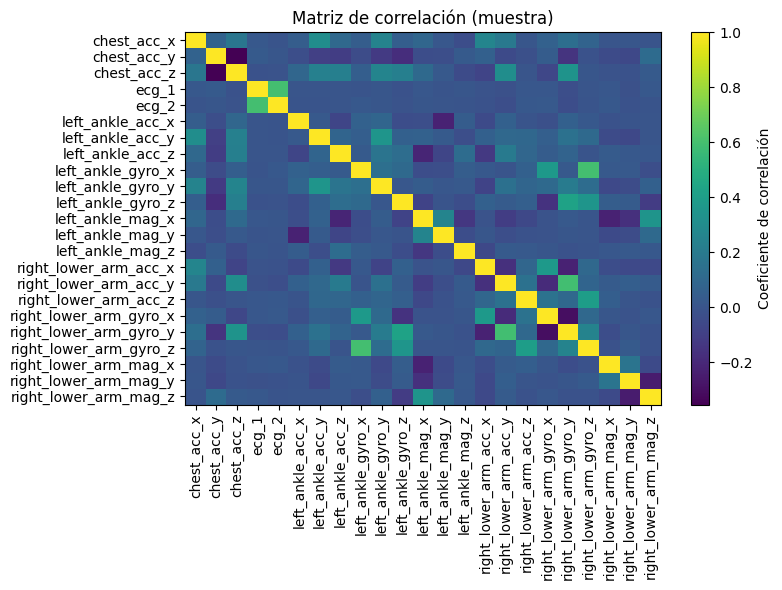

In [14]:
# Usamos una muestra para calcular correlaciones más rápido
n_corr = 150_000 if len(df) > 150_000 else len(df)
sample_corr = df[num_cols].sample(n=n_corr, random_state=RANDOM_STATE)

corr = sample_corr.corr(numeric_only=True)

plt.figure(figsize=(8,6))
plt.imshow(corr, aspect='auto')  # heatmap simple con Matplotlib
plt.colorbar(label="Coeficiente de correlación")
plt.xticks(ticks=np.arange(len(num_cols)), labels=num_cols, rotation=90)
plt.yticks(ticks=np.arange(len(num_cols)), labels=num_cols)
plt.title("Matriz de correlación (muestra)")
plt.tight_layout()
plt.show()


## Limpieza y preprocesamiento

En esta etapa haremos:
1) Revisión y tratamiento de **valores faltantes** (si existieran).  
2) **Detección** y **tratamiento** de **outliers** (valores extremos) con umbrales robustos.  
3) **Estandarización** opcional para hacer comparables las escalas entre señales.


**Tratamiento de outliers:** usamos *winsorización por percentiles* (`OUTLIER_METHOD="pct"`, P1–P99).  
Esto limita picos extremos sin eliminar datos, estabiliza estadísticas y preserva la parte central de la distribución.  
Comprobamos cuántos valores fueron afectados por columna para asegurar que el recorte sea moderado.


In [15]:
# Método de tratamiento de outliers:
#   - "pct"     : winsorización por percentiles (p_low, p_high)
OUTLIER_METHOD = "pct"
P_LOW, P_HIGH = 1.0, 99.0   # se usan si OUTLIER_METHOD == "pct"

# Estandarización:
#   - None       : no estandarizar
#   - "standard" : (x - media)/std
#   - "robust"   : (x - mediana)/IQR (más estable ante outliers)
SCALING = "robust"
# ---------------------------------------------------

# Columnas numéricas (todas menos etiquetas/categorías/ids)
num_cols = [c for c in df.columns if c not in ("label", "activity", "subject_id")]

def winsorize_percentiles(s: pd.Series, p_low=1.0, p_high=99.0) -> tuple[pd.Series, dict]:
    lo, hi = np.percentile(s.values, [p_low, p_high])
    s_clipped = s.clip(lower=lo, upper=hi)
    return s_clipped, {"low": float(lo), "high": float(hi)}

def clip_iqr(s: pd.Series, k=1.5) -> tuple[pd.Series, dict]:
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lo, hi = q1 - k*iqr, q3 + k*iqr
    s_clipped = s.clip(lower=lo, upper=hi)
    return s_clipped, {"q1": float(q1), "q3": float(q3), "iqr": float(iqr), "low": float(lo), "high": float(hi)}

def standard_scale(s: pd.Series) -> tuple[pd.Series, dict]:
    m, sd = float(s.mean()), float(s.std(ddof=0))
    sd = sd if sd > 0 else 1.0
    return (s - m) / sd, {"mean": m, "std": sd}

def robust_scale(s: pd.Series) -> tuple[pd.Series, dict]:
    med = float(s.median())
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = float(q3 - q1)
    denom = iqr if iqr > 0 else 1.0
    return (s - med) / denom, {"median": med, "iqr": iqr}


### Tratamiento de valores faltantes

Como detectamos que no habian **valores faltantes** (`NaN`) saltaremos esta parte.

### Detección y tratamiento de outliers

- **Percentiles (P1–P99)**: recorta valores extremos (*winsorización*), preserva la distribución central.


**Qué registramos:**
- Umbrales usados por columna.
- Número de valores **modificados** (recortados) por columna.

> No eliminamos filas en esta etapa; solo **limitamos** extremos para estabilizar estadísticas y futuras estandarizaciones.


In [16]:
thresholds = {}
changed_counts = {}

X = df[num_cols].copy()

for c in num_cols:
    s = X[c]
    if OUTLIER_METHOD == "pct":
        s2, thr = winsorize_percentiles(s, P_LOW, P_HIGH)
    else:
        s2, thr = s, {}

    thresholds[c] = thr
    changed_counts[c] = int((s2.values != s.values).sum())
    X[c] = s2

df_wins = df.copy()
df_wins[num_cols] = X

print("Valores recortados por columna (top 10):")
display(pd.Series(changed_counts).sort_values(ascending=False).head(10))


Valores recortados por columna (top 10):


,0
left_ankle_acc_x,24316
right_lower_arm_mag_z,24316
left_ankle_mag_z,24316
right_lower_arm_mag_x,24316
right_lower_arm_acc_z,24315
chest_acc_y,24315
right_lower_arm_mag_y,24314
right_lower_arm_acc_y,24313
left_ankle_mag_x,24313
left_ankle_mag_y,24312


### ¿Normalizar o estandarizar? Decisión para este proyecto

Las señales de MHEALTH (acelerómetro, giroscopio, magnetómetro y ECG) tienen **unidades y rangos distintos**.
Además, observamos **outliers** en algunos ejes.

**Por eso elegimos: _estandarización robusta_ (mediana/IQR) por columna**, para poder comparar señales en **misma escala**:
- **Standard z-score:** $z=\frac{x-\mu}{\sigma}$  
- **Robust scaling:** $x_{\mathrm{est}}=\frac{x-\mathrm{mediana}}{\mathrm{IQR}}$




In [17]:
X_scaled = pd.DataFrame(index=df_wins.index)

scaler_params = {}
for c in num_cols:
    if SCALING is None:
        X_scaled[c] = df_wins[c]
        scaler_params[c] = {}
    elif SCALING == "standard":
        X_scaled[c], scaler_params[c] = standard_scale(df_wins[c])
    elif SCALING == "robust":
        X_scaled[c], scaler_params[c] = robust_scale(df_wins[c])
    else:
        raise ValueError("SCALING inválido")

# Armamos un DataFrame final "listo para explorar/modelar" (sin duplicar etiquetas)
df_ready = pd.concat([X_scaled, df_wins[["label", "activity", "subject_id"]]], axis=1)

print("df_ready shape:", df_ready.shape)


df_ready shape: (1215745, 26)


### Verificación rápida: antes vs. después del recorte

Comparamos una columna “sospechosas” para confirmar que los extremos se limitaron,
sin deformar la zona central (percentiles P1–P99 deberían mantenerse muy similares).


Columna: right_lower_arm_mag_z
Percentiles antes: {1: np.float64(-239.3256), 5: np.float64(-96.6986), 50: np.float64(-0.673), 95: np.float64(97.3314), 99: np.float64(239.7612)}
Percentiles después: {1: np.float64(-239.3231), 5: np.float64(-96.6986), 50: np.float64(-0.673), 95: np.float64(97.3314), 99: np.float64(239.7563)}
Valores modificados: 24316


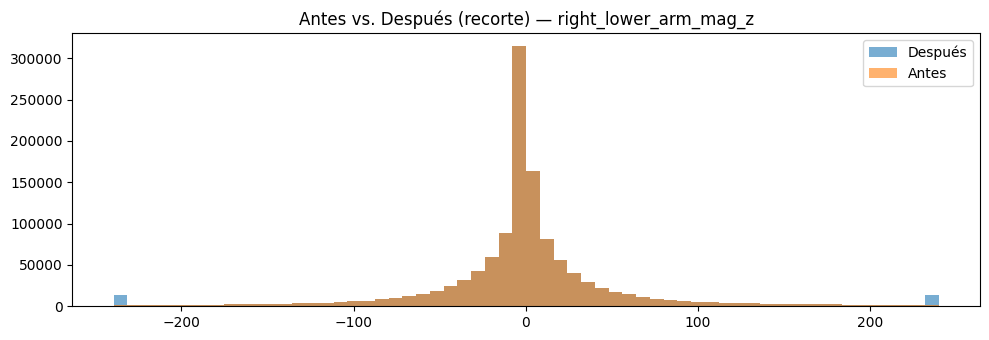

In [18]:
def compare_col(col):
    import matplotlib.pyplot as plt
    s0 = df[col].to_numpy()
    s1 = df_wins[col].to_numpy()

    p = [1, 5, 50, 95, 99]
    p0 = np.percentile(s0, p)
    p1 = np.percentile(s1, p)

    print(f"Columna: {col}")
    print("Percentiles antes:", dict(zip(p, np.round(p0, 4))))
    print("Percentiles después:", dict(zip(p, np.round(p1, 4))))
    print("Valores modificados:", changed_counts[col])

    # Histogramas comparados (rango P1-P99 del original)
    lo, hi = np.percentile(s0, [1, 99])
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,3.5))
    # Dibuja primero el "Después" y luego el "Antes"
    plt.hist(s1[(s1>=lo)&(s1<=hi)], bins=60, alpha=0.6, label="Después")
    plt.hist(s0[(s0>=lo)&(s0<=hi)], bins=60, alpha=0.6, label="Antes")
    plt.title(f"Antes vs. Después (recorte) — {col}")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Ejemplo:
compare_col("right_lower_arm_mag_z")


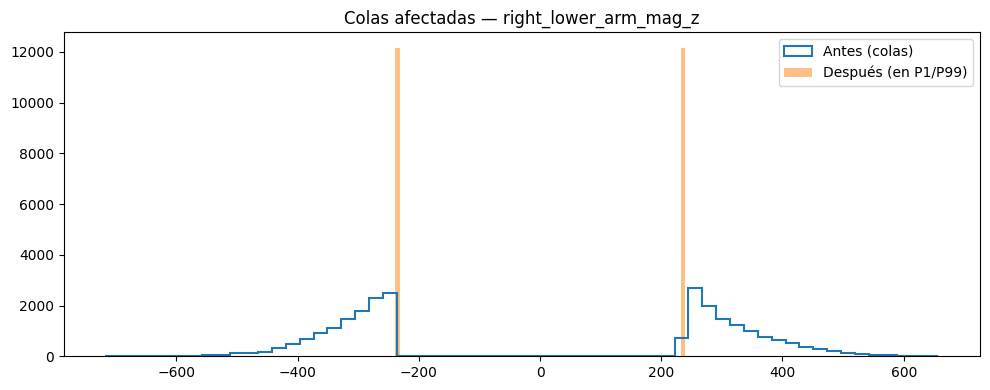

In [19]:
# Solo colas afectadas
def compare_col_tails(col, p_low=1, p_high=99):
    s0 = df[col].to_numpy()
    s1 = df_wins[col].to_numpy()
    lo, hi = np.percentile(s0, [p_low, p_high])

    tail0 = s0[(s0 < lo) | (s0 > hi)]
    tail1 = s1[(s1 <= lo) | (s1 >= hi)]

    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,4))
    plt.hist(tail0, bins=60, histtype="step", linewidth=1.5, label="Antes (colas)")
    plt.hist(tail1, bins=60, alpha=0.5, label="Después (en P1/P99)")
    plt.title(f"Colas afectadas — {col}")
    plt.legend(); plt.tight_layout(); plt.show()

compare_col_tails("right_lower_arm_mag_z")


## Estandarización: ¿qué cambió y cómo leerlo?

**Objetivo.** Después de limitar outliers, aplicamos una **estandarización robusta por columna**: $x_{\mathrm{est}}=\frac{x-\mathrm{mediana}}{\mathrm{IQR}}$, donde IQR es el rango intercuartílico (Q3 − Q1). Esto pone todas las señales en una misma escala y reduce la influencia de valores extremos.


### ¿Qué se ve tras estandarizar?

- **Centro común:** la **mediana** de cada señal queda ≈ **0**.  
- **Escala común:** el **IQR** de cada señal pasa a ser ≈ **1**  
  (por eso **Q1 ≈ −0.5** y **Q3 ≈ +0.5** en las columnas estandarizadas).
- **Forma preservada:** la **estructura** de cada distribución (asimetrías, picos, multimodalidad) se **mantiene**; solo cambia la **unidad** de medida.
- **Comparabilidad:** ahora un valor **+1.0** significa “≈ un IQR por **encima** de la mediana” en *cualquier* sensor; **−1.0**, un IQR por **debajo**.  
  Valores con \|x\| > **3** indican observaciones **muy alejadas** del centro.
- **Etiquetas intactas:** `label`, `activity` y `subject_id` **no** se transforman.

### ¿Por qué robusta y no min–max o z-score clásico?

- **Robusta (mediana/IQR):** menos sensible a outliers residuales y a colas pesadas (común en IMUs/magnetómetros).  
- **Min–max [0,1]:** útil cuando se exige un rango acotado, pero **muy sensible a extremos**.  
- **z-score (media/std):** estándar, aunque la **std** puede inflarse si quedan picos.

### Qué **no** cambió
- No se “inventan” datos ni se reordena nada: solo **re-escalamos**.  
- Las relaciones entre puntos (mayor/menor) **se conservan**.

### Cómo interpretar un gráfico/tabla estandarizados
- Curvas centradas en 0 ⇒ sensor sin sesgo fuerte.  
- Colas más largas en positivo/negativo ⇒ asimetrías reales del movimiento.  
- Comparar dos sensores ahora es directo: **mismas unidades** (IQRs).

> **Conclusión:** con outliers acotados y señales en escala comparable, el dataset queda **listo** para pasos posteriores.
